In [1]:
library(gridExtra)
library(ggplot2)
library(rstan)
library(rstansensitivity)

options(repr.plot.width=8, repr.plot.height=4)

Loading required package: StanHeaders
rstan (Version 2.17.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: reshape2


# Inspect sensitivity

Set paths and load the results from the notebook Sampling_earnings_vary_si.

In [2]:
git_repo_loc <- system("git rev-parse --show-toplevel", intern=TRUE)
example_path <- file.path(git_repo_loc, "examples/earnings_vary_si")
refit_filename <- file.path(example_path, "earnings_vary_si_refit_results.Rdata")
load(refit_filename)

Look at the time taken for different aspects of the analysis.

In [3]:
cat("Sampling time: ", as.numeric(sampling_time, units="secs"), "\n")
cat("Sensitivity time: ", as.numeric(sens_time, units="secs"), "\n")
cat("Refit time: ", as.numeric(refit_time, units="secs"), "\n")

Sampling time:  139.127 
Sensitivity time:  7.124251 
Refit time:  1604.981 


Look at the sensitivities.  The excess sensitivity of mu_a2 to sigma_a2_scale, which we observed in the notebook Sampling_earnings_vary_si.pynb, motivated refitting the model at different values of sigma_a2_scale to see whether there was a real problem.

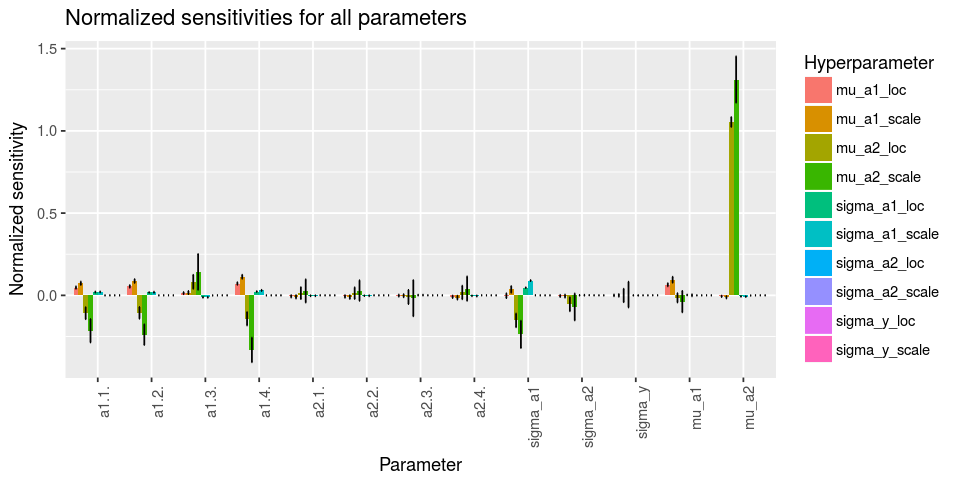

In [4]:
PlotSensitivities(tidy_results) + ggtitle("Normalized sensitivities for all parameters")

Let's make a graph that only shows parameters and hyperparameters that exhibit some excess sensitivity.

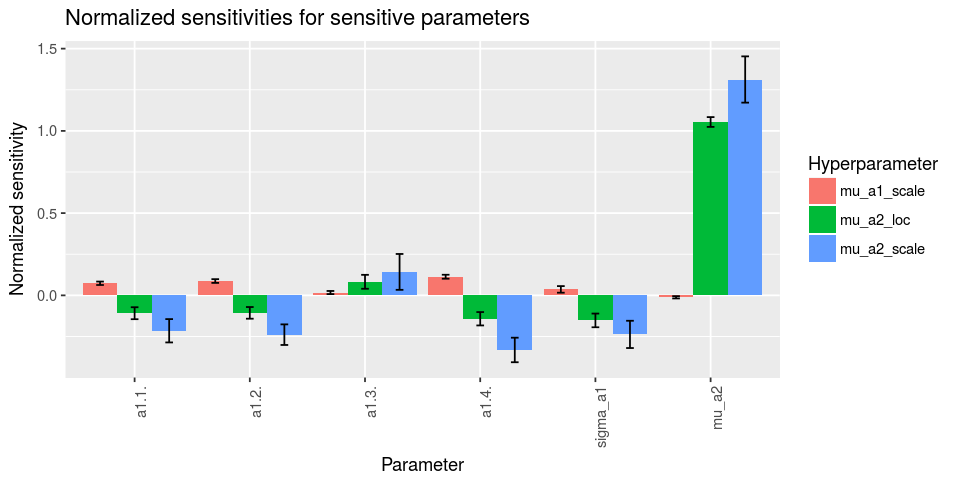

In [5]:
tidy_results <- mutate(tidy_results,
       normalized_sensitivity_lower =
         normalized_sensitivity - 2 * normalized_sensitivity_se,
       normalized_sensitivity_upper =
         normalized_sensitivity + 2 * normalized_sensitivity_se,
       sensitive =
         abs(normalized_sensitivity_lower) > 0.5 |
         abs(normalized_sensitivity_upper) > 0.5)

sens_params_df <- filter(tidy_results,
       sign(normalized_sensitivity_lower) ==
         sign(normalized_sensitivity_upper),
       abs(normalized_sensitivity) > 1e-1)
sens_params <-
  group_by(sens_params_df, parameter) %>% summarize() %>% `[[`("parameter")
sens_hyperparams <-
  group_by(sens_params_df, hyperparameter) %>% summarize() %>% `[[`("hyperparameter")

PlotSensitivities(filter(tidy_results,
                         parameter %in% sens_params,
                         hyperparameter %in% sens_hyperparams)) +
    ggtitle("Normalized sensitivities for sensitive parameters")

We saw a lot of divergent transitions during sampling.  Let's look at how the number of transitions varied with the hyperparameter.

In [6]:
# This will be useful for joining the contents of sampling_result_list
# with the values of mu_a2_scale used to sample.
hyperparam_vals_df <-
  data.frame(hyperparameter_val=hyperparam_vals,
             refit_num=1:length(hyperparam_vals))

In [7]:
traces_list <- list()
refit_num <- 1
for (refit_num in 1:length(sampling_result_list)) {
    this_sampling_result <- sampling_result_list[[refit_num]]
    sampling_diagnostics <- data.frame(get_sampler_params(this_sampling_result))
    sampling_diagnostics$iteration <- 1:nrow(sampling_diagnostics)
    traces <-
      data.frame(traceplot(this_sampling_result,
                           pars=this_sampling_result@model_pars)[[1]]) %>%
      inner_join(sampling_diagnostics, by="iteration") %>%
      mutate(refit_num=refit_num)
    traces_list[[length(traces_list) + 1]] <- traces    
}
traces_df <-
    do.call(rbind, traces_list) %>%
    inner_join(hyperparam_vals_df, by="refit_num")

There are more divergent transitions for higher values of the prior mu_a2_scale.  Something about a non-informative prior is making the model behave badly.

In [8]:
diagnostics_df <-
    group_by(traces_df, hyperparameter_val, refit_num) %>%
    summarize(num_divergent_transitions=sum(divergent__), n_samp=n()) %>%
    mutate(divergent_prop=num_divergent_transitions / n_samp)
print(diagnostics_df)

# A tibble: 10 x 5
# Groups:   hyperparameter_val [10]
   hyperparameter_val refit_num num_divergent_transitions n_samp divergent_prop
                <dbl>     <int>                     <dbl>  <int>          <dbl>
 1              0.200         1                      14.0  69986       0.000200
 2              0.400         2                       0    69986       0       
 3              0.600         3                      28.0  69986       0.000400
 4              0.800         4                      28.0  69986       0.000400
 5              1.00          5                      70.0  69986       0.00100 
 6              1.20          6                      42.0  69986       0.000600
 7              1.40          7                      98.0  69986       0.00140 
 8              1.60          8                     224    69986       0.00320 
 9              1.80          9                     826    69986       0.0118  
10              2.00         10                     938    69986 

Let's take a look at what happens when we change the prior mu_a2_scale and re-fit.  There's some non-linearity, but the linear approximation used by rstansensitivity appears to have picked up a real problem.  mu_a2, in particular, really changes as we change the value of mu_a2_scale.

In [9]:
plot_parameters <- c(sprintf("a1.%d.", 1:4), "mu_a2", "sigma_a1")
plot_df <-
    filter(perturbed_df, parameter %in% plot_parameters) %>%
    inner_join(diagnostics_df, by="hyperparameter_val") %>%
    filter(divergent_prop < 0.002) %>%
    mutate(hyperparameter_diff=hyperparameter_val - stan_data[[hyperparam_name]],
           mean_diff_pred=hyperparameter_diff * sensitivity,
           mean_diff_pred_lower=mean_diff_pred - 2 * se_mean.orig -
                                2 * sign(hyperparameter_diff) *
                                sensitivity_se * hyperparameter_diff,
           mean_diff_pred_upper=mean_diff_pred + 2 * se_mean.orig +
                                2 * sign(hyperparameter_diff) *
                                sensitivity_se * hyperparameter_diff
        )

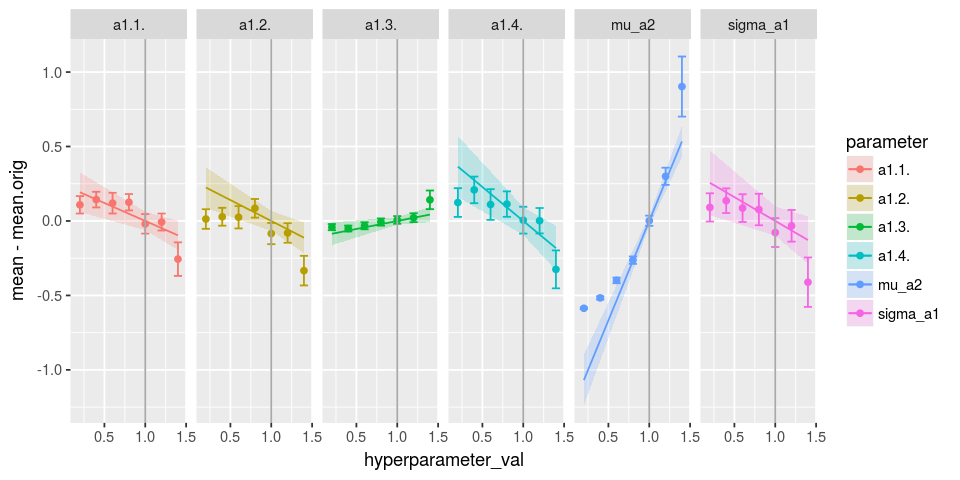

In [10]:
ggplot(plot_df) +
    geom_point(aes(x=hyperparameter_val, y=mean - mean.orig, color=parameter, group=parameter)) +
    geom_errorbar(aes(x=hyperparameter_val,
                      ymin=mean - mean.orig - 2 * se_mean,
                      ymax=mean - mean.orig + 2 * se_mean,
                      color=parameter, group=parameter), width=0.1) +
    geom_line(aes(x=hyperparameter_val,
                  y=mean_diff_pred,
                  color=parameter, group=parameter)) +
    geom_ribbon(aes(x=hyperparameter_val,
                    ymin=mean_diff_pred_lower,
                    ymax=mean_diff_pred_upper,
                    fill=parameter, group=parameter), color=NA, alpha=0.2) +
    geom_vline(aes(xintercept=stan_data[[hyperparam_name]]), color="dark gray") +
    facet_grid( ~ parameter)

A natural thing to do would be to make the prior less informative.  In fact, a variance of 1 seems like it might be a little small.  However, the divergent transitions are a problem.  Let's look at the actual draws and see if we can tell what's going on, especially with the divergent transitions.

In [11]:
params <- sampling_result_list[[1]]@model_pars
refit_draws_list <- list()
refit_num <- 1
for (sampling_result_perturbed in sampling_result_list) {
  refit_draws <- as.data.frame(sampling_result_perturbed, pars=params)
  refit_draws$refit_num <- refit_num
  refit_draws$draw <- 1:nrow(refit_draws)
  refit_num <- refit_num + 1
  refit_draws_list[[length(refit_draws_list) + 1]] <- refit_draws
}

# Get a dataframe of draws with mu_a1 and mu_a2 rescaled to be on the same scale as a1 and a2.
refit_draws_by_param <-
  do.call(rbind, refit_draws_list) %>%
  inner_join(hyperparam_vals_df, by="refit_num") %>%
  select(-refit_num) %>%
  mutate(mu_a1_rescale = 10 * mu_a1, mu_a2_rescale = 0.01 * mu_a2) %>%
  select(-mu_a1, -mu_a2)

As you change the a2 scale prior, sigma_a1 is getting smaller and smaller, and the mu_a2 distribution first spreads out then collapses again.

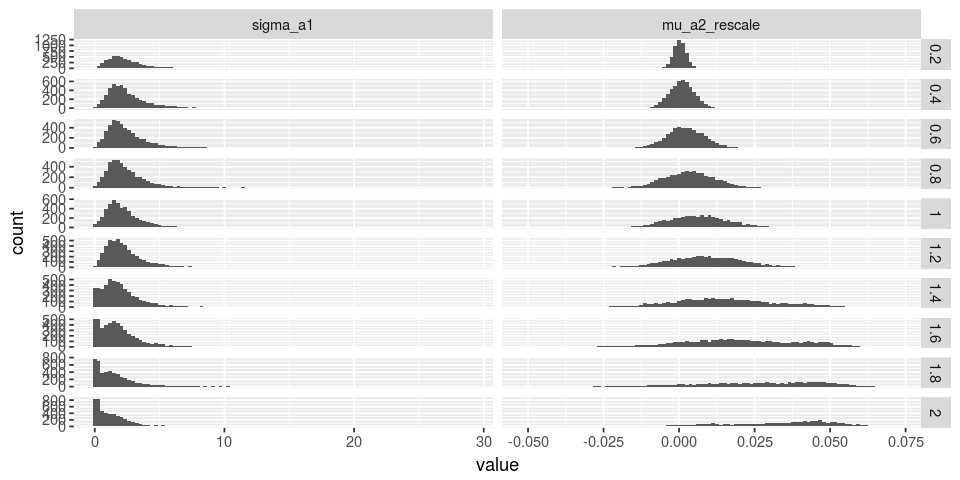

In [12]:
refit_draws <-
  melt(refit_draws_by_param, id.vars=c("hyperparameter_val", "draw"))

ggplot(filter(refit_draws, variable %in% c("sigma_a1", "mu_a2_rescale"))) +
  geom_histogram(aes(x=value), bins=100) +
  facet_grid(hyperparameter_val ~ variable, scales="free")

Looking at the variability of the a2 values, we see that mu2 should really be taking values > 0.04 / 0.01 = 4.  This is pretty unlikely with a N(0, 1) prior, so we're way over-shrinking mu2  and, in turn, the a2 values.

In [13]:
a2_summary <-
  filter(refit_draws, grepl("^a2\\[", variable)) %>%
  group_by(hyperparameter_val) %>%
  summarize(mean=mean(value), sd=sd(value))
print(a2_summary)

mu_a2_summary <-
  filter(refit_draws, variable == "mu_a2_rescale") %>%
  group_by(hyperparameter_val) %>%
  summarize(mean=mean(value), sd=sd(value))
print(mu_a2_summary)

# A tibble: 10 x 3
   hyperparameter_val   mean     sd
                <dbl>  <dbl>  <dbl>
 1              0.200 0.0315 0.0278
 2              0.400 0.0310 0.0279
 3              0.600 0.0314 0.0274
 4              0.800 0.0311 0.0270
 5              1.00  0.0326 0.0261
 6              1.20  0.0325 0.0258
 7              1.40  0.0352 0.0240
 8              1.60  0.0365 0.0230
 9              1.80  0.0394 0.0215
10              2.00  0.0404 0.0205
# A tibble: 10 x 3
   hyperparameter_val     mean      sd
                <dbl>    <dbl>   <dbl>
 1              0.200 0.000233 0.00201
 2              0.400 0.000931 0.00401
 3              0.600 0.00211  0.00605
 4              0.800 0.00346  0.00808
 5              1.00  0.00611  0.0102 
 6              1.20  0.00910  0.0127 
 7              1.40  0.0151   0.0170 
 8              1.60  0.0204   0.0188 
 9              1.80  0.0265   0.0204 
10              2.00  0.0306   0.0202 


This is born out in the data.  As the prior on mu2 becomes more relaxed, the mean goes from way outside the center of the a2 points in towards the center.

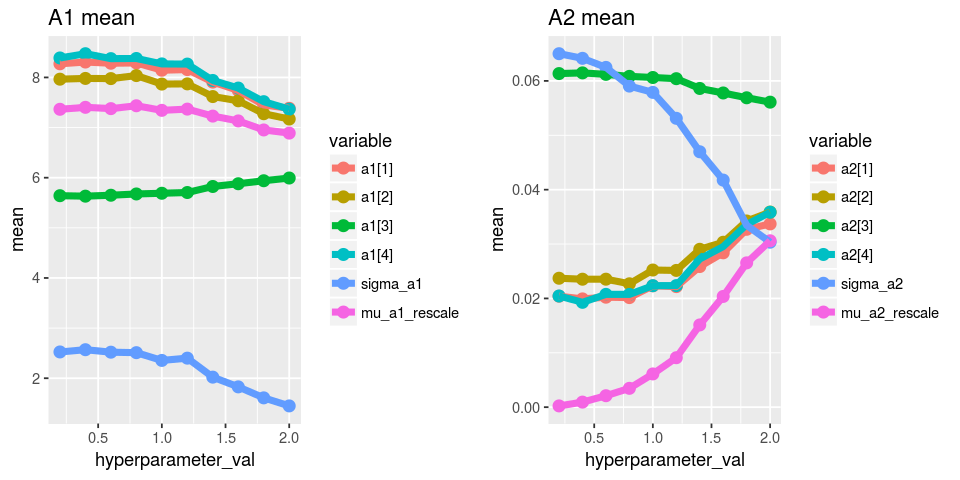

In [14]:
refit_summary <- 
  filter(refit_draws, !grepl("eta", variable)) %>%
  group_by(hyperparameter_val, variable) %>%
  summarize(mean=mean(value), sd=sd(value))

grid.arrange(
  ggplot(filter(refit_summary, grepl("a1", variable)),
         aes(x=hyperparameter_val, y=mean, color=variable)) +
    geom_point(size=3) + geom_line(size=2) + ggtitle("A1 mean")
  ,
  ggplot(filter(refit_summary, grepl("a2", variable)),
         aes(x=hyperparameter_val, y=mean, color=variable)) +
    geom_point(size=3) + geom_line(size=2) + ggtitle("A2 mean")
  , ncol=2
)


Note that group three has an appreciable amount of data, which is why it's value of a2 is more resistant to the over-shrunken mu_a2.

In [15]:
print(table(stan_data$eth))


  1   2   3   4 
104  61 873  21 


Consequently, all but group 3 has their a2 value significantly affected by the unusually small values of mu_a2.  (This can also be seen in the graphs.) Note that the posterior posteriors of the a2 variables start to
overlap when they are not shrunk so much.

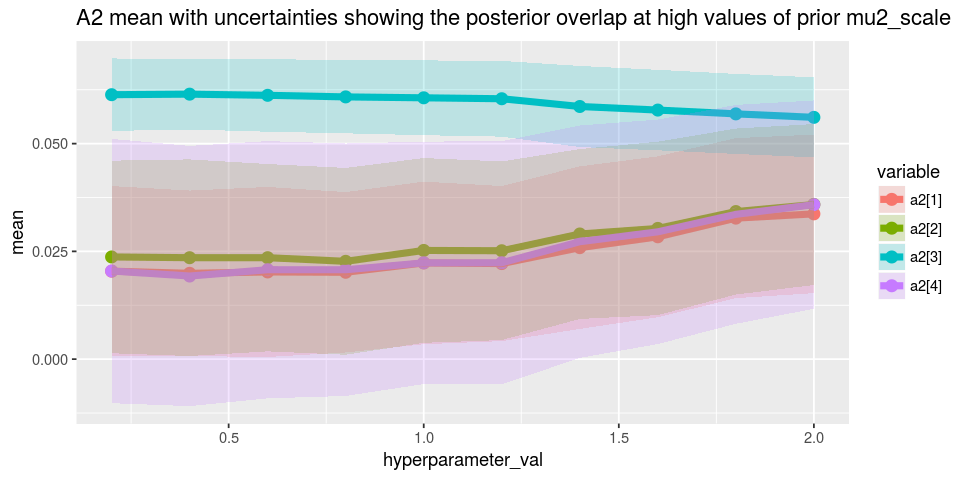

In [16]:
ggplot(filter(refit_summary, grepl("a2\\[", variable))) +
  geom_point(aes(x=hyperparameter_val, y=mean, color=variable), size=3) +
  geom_line(aes(x=hyperparameter_val, y=mean, color=variable), size=2) +
  geom_ribbon(aes(x=hyperparameter_val,
                  ymin=mean - sd,
                  ymax=mean + sd,
                  fill=variable), color=NA, alpha=0.2) +
  ggtitle("A2 mean with uncertainties showing the posterior overlap at high values of prior mu2_scale")


If all the a2 values are the same, then the posterior admits the degenerate point with mu_a2 = a2 and sigma_a2 = 0.  This becomes possible when we don't over-shrink. Without the influence of the prior, the model is degenerate!



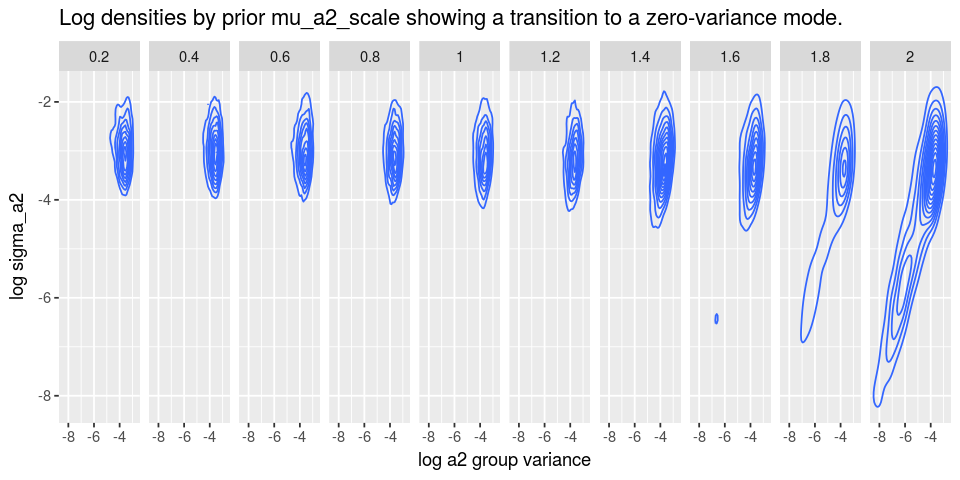

In [17]:
group_draw_summaries <-
    mutate(refit_draws, variable_group=sub("\\[.*\\]$", "", variable)) %>%
    filter(variable_group %in% c("a1", "a2")) %>%
    ungroup() %>% group_by(variable_group, draw, hyperparameter_val) %>%
    summarize(group_mean=mean(value), group_sd=sd(value)) %>%
    dcast(hyperparameter_val + draw ~ variable_group, value.var="group_sd") %>%
    inner_join(refit_draws, by=c("hyperparameter_val", "draw"))

ggplot(filter(group_draw_summaries, variable == "sigma_a2")) +
    geom_density_2d(aes(x=log(a2), y=log(value))) +
    xlab("log a2 group variance") + ylab("log sigma_a2") +
    facet_grid( ~ hyperparameter_val) +
    ggtitle("Log densities by prior mu_a2_scale showing a transition to a zero-variance mode.")

By fixing the parameterization and widening the prior, we can confirm that only the informative prior is allowing significant posterior mass with non-zero group variance. 

In [30]:
rstan_options(auto_write=TRUE)

# Compile the models.
base_model_name <- file.path(example_path, "models/earnings_vary_si_corrected.stan")
model_name <- GenerateSensitivityFromModel(base_model_name)
model <- stan_model(paste(model_name, "_generated.stan", sep=""))
stan_sensitivity_list <- GetStanSensitivityModel(model_name, stan_data)


hash mismatch so recompiling; make sure Stan code ends with a blank line


In file included from /usr/local/lib/R/site-library/BH/include/boost/config.hpp:39:0,
                 from /usr/local/lib/R/site-library/BH/include/boost/math/tools/config.hpp:13,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math.hpp:4,
                 from /usr/local/lib/R/site-library/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file18a44a981ecd.cpp:8:
/usr/local/lib/R/site-library/BH/include/boost/config/compiler/gcc.hpp:186:0: warning: "BOOST_NO_CXX11_RVALUE_REFERENCES" redefined
 #  define BOOST_NO_CXX11_RVALUE_RE

recompiling to avoid crashing R session


In file included from /usr/local/lib/R/site-library/BH/include/boost/config.hpp:39:0,
                 from /usr/local/lib/R/site-library/BH/include/boost/math/tools/config.hpp:13,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math.hpp:4,
                 from /usr/local/lib/R/site-library/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file18a4207826e7.cpp:8:
/usr/local/lib/R/site-library/BH/include/boost/config/compiler/gcc.hpp:186:0: warning: "BOOST_NO_CXX11_RVALUE_REFERENCES" redefined
 #  define BOOST_NO_CXX11_RVALUE_RE

hash mismatch so recompiling; make sure Stan code ends with a blank line


In file included from /usr/local/lib/R/site-library/BH/include/boost/config.hpp:39:0,
                 from /usr/local/lib/R/site-library/BH/include/boost/math/tools/config.hpp:13,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math.hpp:4,
                 from /usr/local/lib/R/site-library/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file18a4775eb600.cpp:8:
/usr/local/lib/R/site-library/BH/include/boost/config/compiler/gcc.hpp:186:0: warning: "BOOST_NO_CXX11_RVALUE_REFERENCES" redefined
 #  define BOOST_NO_CXX11_RVALUE_RE

In [31]:
# Sample

# For reproducibility:
set.seed(42)

data_path <- file.path(example_path, "earnings_vary_si.data.R")

stan_data <- new.env()
source(data_path, local=stan_data)
stan_data <- as.list(stan_data)
stan_data$mu_a1_scale <- 10
stan_data$mu_a2_scale <- 10

iters <- 10000
adapt_delta <- 0.99

fixed_sampling_result <- sampling(
  model, data=stan_data, iter=iters, chains=1, control=list(adapt_delta=adapt_delta))


SAMPLING FOR MODEL 'earnings_vary_si_corrected_generated' NOW (CHAIN 1).

Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 176.988 seconds (Warm-up)
               236.649 seconds (Sampling)
               413.637 seconds (Total)



Warning message:
“There were 8 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 4162 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

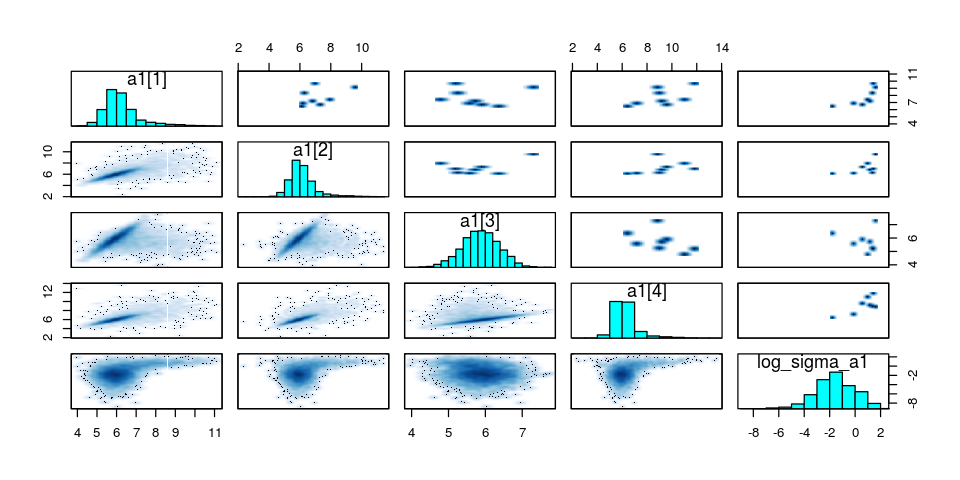

In [32]:
pairs(fixed_sampling_result, pars=c("a1", "log_sigma_a1"), condition="divergent__")

In [20]:
# Calculate the sensitivity.
fixed_sens_result <- GetStanSensitivityFromModelFit(fixed_sampling_result, stan_sensitivity_list)
fixed_tidy_results <- GetTidyResult(fixed_sens_result)

Evaluating sensitivity model at the MCMC draws for chain  1 .
  |======================================================================| 100%


Warning message in mcmcse::mcse.multi(arg_draws):
“You either need more samples or x is not full column rank”Warning message in log(sig.eigen):
“NaNs produced”Warning message in mcmcse::mcse.multi(arg_draws):
“You either need more samples or x is not full column rank”Warning message in log(sig.eigen):
“NaNs produced”Warning message in mcmcse::mcse.multi(par_draws):
“You either need more samples or x is not full column rank”Warning message in log(sig.eigen):
“NaNs produced”Warning message in mcmcse::mcse.multi(par_draws):
“You either need more samples or x is not full column rank”Warning message in log(sig.eigen):
“NaNs produced”Warning message in mcmcse::mcse.multi(par_draws):
“You either need more samples or x is not full column rank”Warning message in log(sig.eigen):
“NaNs produced”

Inference for Stan model: earnings_vary_si_corrected_generated.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

         mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
sigma_a2 0.02    0.01 0.04 0.00 0.00 0.00 0.01  0.12    11 1.10
a1[1]    6.39    0.22 0.99 4.98 5.72 6.15 6.81  8.58    20 1.05
a1[2]    6.56    0.36 1.45 4.91 5.67 6.10 6.74 10.14    16 1.05
a1[3]    5.88    0.02 0.49 4.94 5.58 5.87 6.20  6.86   488 1.00
a1[4]    6.85    0.63 2.16 4.94 5.73 6.15 6.78 13.14    12 1.10

Samples were drawn using NUTS(diag_e) at Fri Jan 19 10:09:05 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: earnings_vary_si_generated.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

         mean se_mean   sd 2.

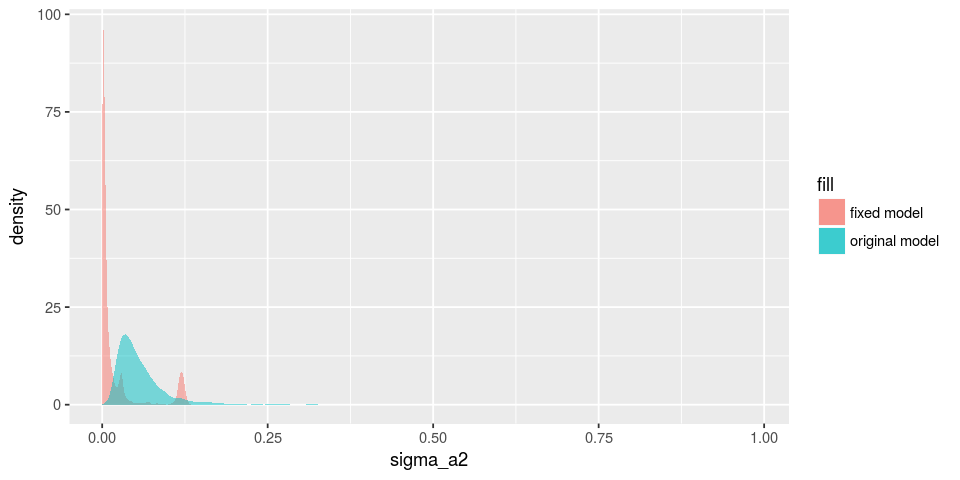

In [19]:
print(fixed_sampling_result, pars=c("sigma_a2", sprintf("a1[%d]", 1:4)))
print(sampling_result, pars=c("sigma_a2", sprintf("a1[%d]", 1:4)))

ggplot() +
    geom_density(aes(x=extract(fixed_sampling_result, pars="sigma_a2")[[1]],
                       fill="fixed model"), alpha=0.5, color=NA) +
    geom_density(aes(x=extract(sampling_result, pars="sigma_a2")[[1]],
                       fill="original model"), alpha=0.5, color=NA) +
    xlab("sigma_a2")

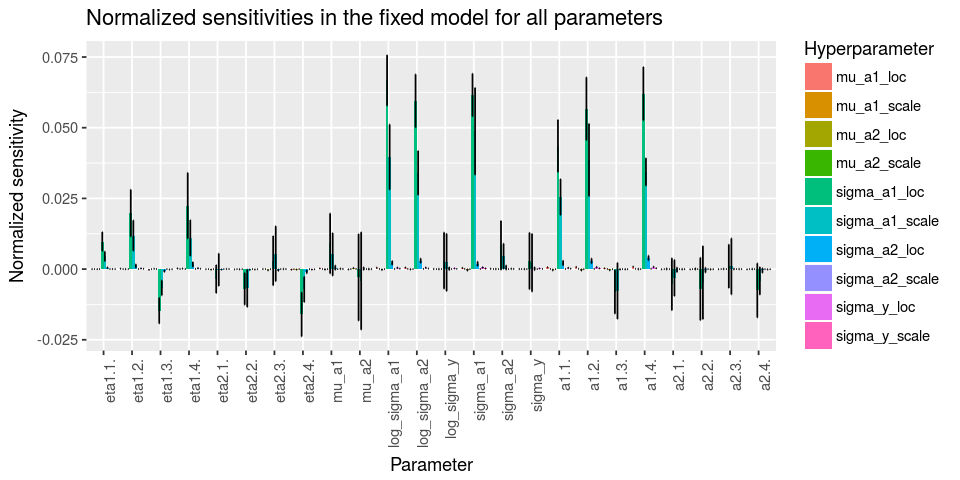

In [21]:
PlotSensitivities(fixed_tidy_results) +
  ggtitle("Normalized sensitivities in the fixed model for all parameters")